In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import drug2cell as d2c
import blitzgsea as blitz
#import loompy
import matplotlib as mpl

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

In [2]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/CTCL_all_final_20240707.h5ad'
adata = sc.read_h5ad(input_file)

In [3]:
adata

AnnData object with n_obs × n_vars = 419579 × 15790
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'cell_type', 'barcode', 'type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'cell_type_colors', 'donor_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'tech_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [4]:
adata_sub = adata[adata.obs['cell_type'].isin(['B_cell','tumor_cell',
                                               'Tc','Tc17_Th17', 'Tc_IL13_IL22','Th','Treg'])].copy()

In [5]:
adata_sub.obs['cell_type'].value_counts()

tumor_cell      102367
Th               52824
Tc               39889
Treg             27614
B_cell           15211
Tc17_Th17         4233
Tc_IL13_IL22      2336
Name: cell_type, dtype: int64

In [6]:
adata_sub.obs['categ'] = "benign_T"
adata_sub.obs.loc[adata_sub.obs['cell_type']=='tumor_cell', 'categ'] = 'tumor_cell'
adata_sub.obs.loc[adata_sub.obs['cell_type']=='B_cell', 'categ'] = 'B_cell'
#adata_sub.obs.loc[adata_sub.obs['cell_type']=='Plasma', 'categ'] = 'B/plasma'

In [7]:
type_con = [i + '_' +j for i, j in zip(list(adata_sub.obs['categ']), list(adata_sub.obs['donor']))]
adata_sub.obs['categ2'] = type_con

In [8]:
adata_sub.obs.loc[adata_sub.obs['categ']=='benign_T', 'categ2'] = 'benign_T'
adata_sub.obs.loc[adata_sub.obs['categ']=='B_cell', 'categ2'] = 'B_cell'

In [9]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell
    finished (0:00:13): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [10]:
d2c.score(adata_sub, use_raw=True)

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/drug2cell/__init__.py:208: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata.uns['drug2cell'] = anndata.AnnData(scores, obs=adata.obs)


In [11]:
adata_sub.uns['drug2cell']

AnnData object with n_obs × n_vars = 244474 × 2234
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'cell_type', 'barcode', 'type', 'categ', 'categ2'
    var: 'genes', 'all_genes'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'

In [12]:
results_file = '/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/CTCL_all_final_20240707_for_d2c.h5ad'
adata_sub.write(results_file)

In [2]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/CTCL_all_final_20240707_for_d2c.h5ad'
adata_sub = sc.read_h5ad(input_file)

In [13]:
sc.tl.rank_genes_groups(adata_sub.uns['drug2cell'], groupby = 'categ', method = 'wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:50)


In [14]:
result = adata_sub.uns['drug2cell'].uns['rank_genes_groups']
groups = result['names'].dtype.names
markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
markers.head(10)
markers.to_csv('drug2cell_DEGs_tumourcell_Bcell_only_donor_Others.csv')

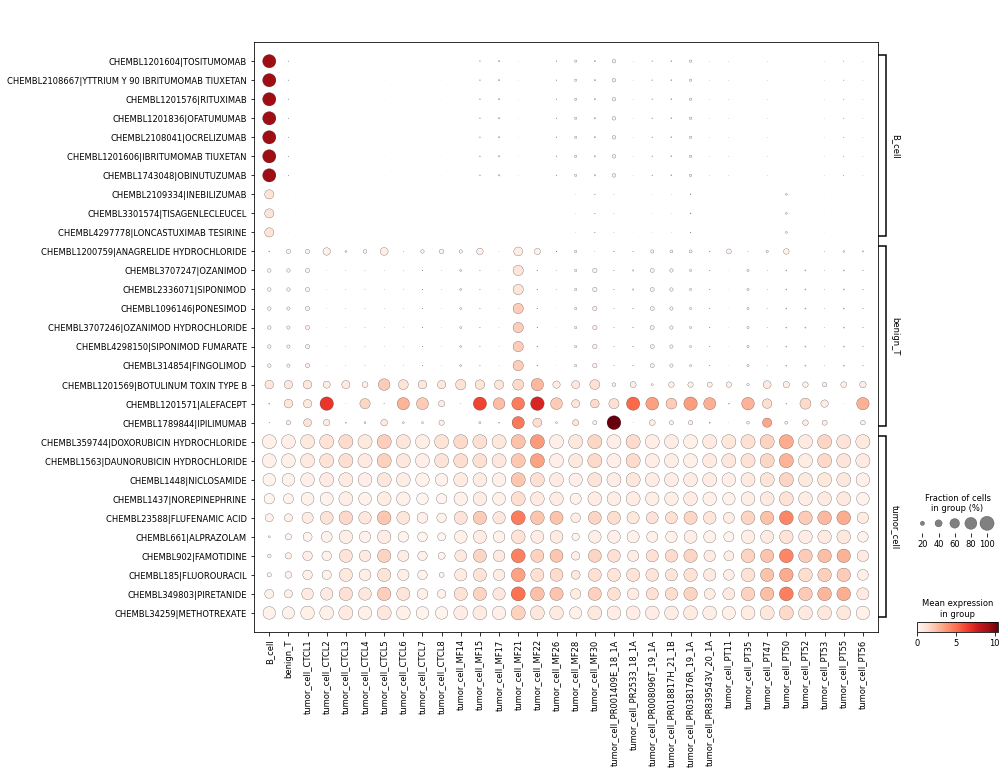

In [15]:
sc.pl.rank_genes_groups_dotplot(adata_sub.uns['drug2cell'], swap_axes=True, dendrogram=False, n_genes=10, groupby = 'categ2')

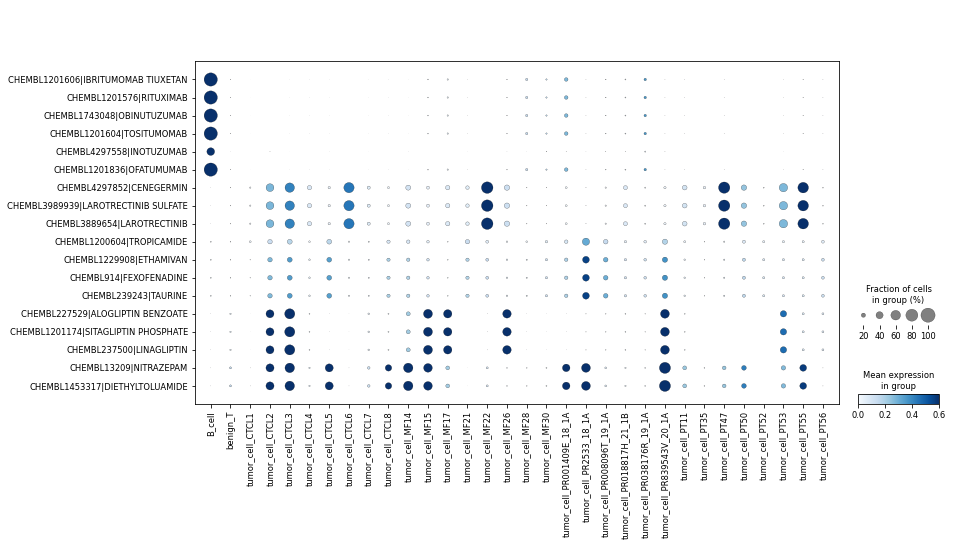

In [21]:
#categories_order = ['Others_Healthy','Others_AD','Others_Psoriasis','Others_CTCL','tumourcell_CTCL']

var_names = ['CHEMBL1201606|IBRITUMOMAB TIUXETAN','CHEMBL1201576|RITUXIMAB','CHEMBL1743048|OBINUTUZUMAB','CHEMBL1201604|TOSITUMOMAB','CHEMBL1201836|OFATUMUMAB',
             'CHEMBL4297852|CENEGERMIN','CHEMBL3989939|LAROTRECTINIB SULFATE',
             'CHEMBL3889654|LAROTRECTINIB','CHEMBL1200604|TROPICAMIDE','CHEMBL1229908|ETHAMIVAN','CHEMBL914|FEXOFENADINE',
             'CHEMBL239243|TAURINE','CHEMBL227529|ALOGLIPTIN BENZOATE','CHEMBL1201174|SITAGLIPTIN PHOSPHATE','CHEMBL237500|LINAGLIPTIN',
             'CHEMBL13209|NITRAZEPAM', 'CHEMBL1453317|DIETHYLTOLUAMIDE']
sc.pl.rank_genes_groups_dotplot(adata_sub.uns['drug2cell'], var_names=var_names, swap_axes=True, dendrogram=False, groupby = 'categ2',
                                cmap = 'Blues', vmax=0.6)
